### Sửa bài 7.19 - Thống Kê Nhiều Chiều - Nhóm 6
###Nguyễn Đức Vũ Duy - 18110004
###Đinh Anh Huy - 18110103

In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import f
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Một ứng dụng vệ tinh kích thích bởi sự phát triển của một loại pin silver_zino. Bảng 7.5 bao gồm các dữ liệu thất bại được thu thập để nghiên cứu tính hiệu quả của cục pin trong chu kì sống của nó. Sử dụng bộ dữ liệu này để:

###a) Tìm ước lượng hồi quy tuyến tính của ln(Y) trong bộ tập con các biến dự đoán phù hợp

In [2]:
path='/content/T7-5.DAT.txt'
df=pd.DataFrame(np.loadtxt(path))
df.head()

,0,1,2,3,4,5
0,0.375,3.13,60.0,40.0,2.00,101.0
1,1.000,3.13,76.8,30.0,1.99,141.0
2,1.000,3.13,60.0,20.0,2.00,96.0
3,1.000,3.13,60.0,20.0,1.98,125.0
4,1.625,3.13,43.2,10.0,2.01,43.0


In [3]:
df.iloc[:,5]=np.log(df.iloc[:,5])
df.head()

,0,1,2,3,4,5
0,0.375,3.13,60.0,40.0,2.00,4.615121
1,1.000,3.13,76.8,30.0,1.99,4.948760
2,1.000,3.13,60.0,20.0,2.00,4.564348
3,1.000,3.13,60.0,20.0,1.98,4.828314
4,1.625,3.13,43.2,10.0,2.01,3.761200


In [4]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [5]:
#Initialization variables
Y = df.iloc[:,5]
X = df.iloc[:,:5]
k = 5

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [6]:
def adjusted_r_square(r,n,p):
  return 1-(1-r)*(n-1)/(n-p-1)

Sử dụng hệ số $R^2$ có hiệu chỉnh có công thức là:
\begin{equation*}
r=1-(1-R^2)\dfrac{n-1}{n-p-1}
\end{equation*}

In [7]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS','|R^2 coefficient')
display([(i,features_list[i], RSS_list[i],adjusted_r_square(R_squared_list[i],df.shape[0],i)) for i in range(1,6)])

Forward stepwise subset selection
Number of features | Features | RSS |R^2 coefficient


[(1, [3], 23.002033242783682, 0.4900196878616795),
 (2, [3, 1], 19.01410682028911, 0.5536385324260749),
 (3, [3, 1, 4], 17.039434517883574, 0.5749941734425128),
 (4, [3, 1, 4, 0], 16.523450642393016, 0.560388365988296),
 (5, [3, 1, 4, 0, 2], 16.03179517635035, 0.5430025163620834)]

Từ đây, ta sẽ chọn 3 ẩn là 1, 3, 4 vì có hệ số $R^2$ hiệu chỉnh cao nhất.

In [8]:
#Construct Z, Y
Z=np.concatenate(((np.ones((df.shape[0],1)),df.iloc[:,1:2],df.iloc[:,3:4],df.iloc[:,4:5])),axis=1)
Y=df.iloc[:,5].values

In [9]:
a=np.linalg.inv(np.matmul(Z.T,Z))
b=np.matmul(Z.T,Y)
beta_hat=np.matmul(np.matmul(a,Z.T),Y)
beta_hat

array([-64.43215359,  -0.33647019,   0.11754121,  33.59708406])

Từ đây, phương trình hồi quy tuyến tính từ bộ tập con các biến phù hợp là: $ln(Y)=-64.432 -0.336z_1+0.1175z_3+33.597z_4$

Ta có dự đoán $\hat{y}$ cần tìm sẽ là

In [10]:
y_hat=np.matmul(Z,beta_hat)
y_hat

array([6.41051131, 4.89912835, 4.05968707, 3.38774539, 3.22024579,
       4.05968707, 4.73162875, 2.59104653, 1.91910485, 4.94187077,
       3.43048781, 1.91910485, 3.85280976, 3.18086808, 5.86766315,
       2.3414268 , 5.53169231, 4.69225104, 4.89912835, 4.05968707])

###b) Vẽ sai số từ model đã fit ở phần a để kiểm tra giả định về tính chuẩn.

In [11]:
residuals=Y-y_hat
residuals

array([-1.79539079,  0.04963154,  0.50466112,  1.44056835,  0.54095432,
       -1.28709835,  0.50481321, -0.28846144, -0.82049256,  1.0139666 ,
        0.37617468, -1.22595767,  0.47792358,  1.17584075, -0.79248934,
       -1.24281451, -0.1564139 , -0.40179159,  0.85026464,  1.07611137])

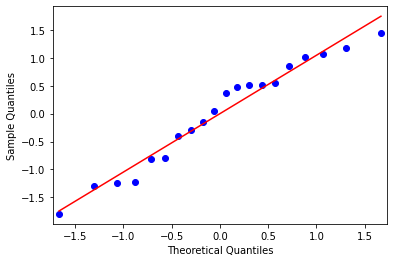

In [12]:
import pylab
import statsmodels.api as sm
sm.qqplot(residuals,line='r')
plt.show()

Theo đồ thị q-q plot thì ta thấy sai số của model trên sẽ tuân theo phân phối chuẩn.